# Overview



## Imports/Settings

In [41]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import os

import glob
import holidays
from holidays import country_holidays

import itertools

import pmdarima as pm
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

plt.rcParams['figure.figsize']=(12,3)

In [2]:
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

## Functions

In [3]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [43]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [44]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [45]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

## Data Prep

### Concat all csv into 1 DF

In [4]:
# Define the directory where your CSV files are located
csv_directory = 'Data/ZipData/'

# List all CSV files in the directory
csv_files = [os.path.join(csv_directory, filename) for filename in os.listdir(csv_directory) if filename.endswith('.csv')]

In [5]:
# Create an empty list to hold the DataFrames
dfs = []

# Loop through your CSV files and read them into DataFrames
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

# Concatenate the DataFrames into one
concatenated_df = pd.concat(dfs, ignore_index=True)



In [6]:
concatenated_df.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,12149675,01/01/2019 01:00:00 PM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,611,6.0,17.0,41.751612,-87.671958
1,11574022,01/01/2019 01:00:00 AM,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,1834,18.0,42.0,41.892659,-87.616600
2,11559315,01/01/2019 01:00:00 PM,ASSAULT,AGGRAVATED - HANDGUN,STREET,True,True,1022,10.0,24.0,41.862529,-87.703930
3,11553582,01/01/2019 01:00:00 AM,THEFT,OVER $500,APARTMENT,False,True,1923,19.0,46.0,41.949460,-87.651974
4,12339426,01/01/2019 01:00:00 PM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,824,8.0,16.0,NaN,NaN


In [7]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 603.2+ MB


### Set index as DateTime

In [8]:
# Convert our Date to Datetime dtype
concatenated_df['Date'] = pd.to_datetime(concatenated_df['Date'], format = '%m/%d/%Y %H:%M:%S %p')
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 603.2+ MB


In [9]:
# Set the DateTime as the index
concatenated_df = concatenated_df.set_index(['Date'])
concatenated_df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2019-01-01 01:00:00,12149675,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,611,6.0,17.0,41.751612,-87.671958
2019-01-01 01:00:00,11574022,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,1834,18.0,42.0,41.892659,-87.616600
2019-01-01 01:00:00,11559315,ASSAULT,AGGRAVATED - HANDGUN,STREET,True,True,1022,10.0,24.0,41.862529,-87.703930
2019-01-01 01:00:00,11553582,THEFT,OVER $500,APARTMENT,False,True,1923,19.0,46.0,41.949460,-87.651974
2019-01-01 01:00:00,12339426,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,824,8.0,16.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2003-12-31 12:50:12,3116762,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,1423,14.0,26.0,41.905026,-87.692003
2003-12-31 12:55:00,3121312,MOTOR VEHICLE THEFT,"ATT: TRUCK, BUS, MOTOR HOME",STREET,False,False,1131,11.0,24.0,41.875043,-87.743319
2003-12-31 12:55:00,3112374,PUBLIC PEACE VIOLATION,FALSE POLICE REPORT,STREET,False,False,2234,22.0,34.0,41.684928,-87.653656


In [10]:
# Organize our Dataframe by Time // Index
concatenated_df = concatenated_df.sort_index()
concatenated_df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,3206463,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,True,835,8.0,18.0,41.735507,-87.690095
2001-01-01 01:00:00,1314713,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,1322,12.0,NaN,41.899521,-87.672220
2001-01-01 01:00:00,1317937,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,334,3.0,NaN,41.762514,-87.565877
2001-01-01 01:00:00,3212105,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,True,False,913,9.0,14.0,41.823730,-87.698440
2001-01-01 01:00:00,1310824,THEFT,$500 AND UNDER,BAR OR TAVERN,False,False,323,3.0,NaN,41.765484,-87.621836
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 12:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


### Save as CSV

In [11]:
#Removed due to file to large to commit. Stored locally for future use.

#concatenated_df.to_csv('Chicago_combined_data.csv', index=False)

In [12]:
# Create a copy of the DF to use for analysis
crime_df = concatenated_df.copy()

# Part 1:

Business Analysis // Stakeholder Questions

## Topic 1: Comparing Police Districs

- Which District had the most crimes in 2022?
- Which had the least?

In [13]:
df_1 = crime_df.loc['2022']
df_1.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2022-01-01 01:00:00,12606858,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,621,6.0,17.0,41.757732,-87.644528
2022-01-01 01:00:00,12582058,ASSAULT,AGGRAVATED - HANDGUN,RESIDENCE,False,False,1412,14.0,35.0,41.933254,-87.713132
2022-01-01 01:00:00,12582776,BATTERY,AGGRAVATED DOMESTIC BATTERY - KNIFE / CUTTING ...,APARTMENT,False,True,2432,24.0,49.0,42.003582,-87.660816
2022-01-01 01:00:00,12582793,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1831,18.0,42.0,41.889453,-87.627995
2022-01-01 01:00:00,12582216,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,RESIDENCE,False,True,1031,10.0,22.0,41.841722,-87.723261


In [14]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238858 entries, 2022-01-01 01:00:00 to 2022-12-31 12:59:00
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    238858 non-null  int64  
 1   Primary Type          238858 non-null  object 
 2   Description           238858 non-null  object 
 3   Location Description  238011 non-null  object 
 4   Arrest                238858 non-null  bool   
 5   Domestic              238858 non-null  bool   
 6   Beat                  238858 non-null  int64  
 7   District              238858 non-null  float64
 8   Ward                  238848 non-null  float64
 9   Latitude              233085 non-null  float64
 10  Longitude             233085 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(3)
memory usage: 18.7+ MB


In [15]:
#Seperate out our key features
df_1 = df_1['District']

#Count by District
count = df_1.value_counts()
count

8.0     14805
6.0     14694
12.0    14341
4.0     13931
11.0    13457
1.0     13044
18.0    12429
19.0    12243
25.0    11951
3.0     11937
2.0     11793
9.0     10376
7.0     10319
10.0     9961
5.0      9773
16.0     9226
24.0     8469
15.0     8308
14.0     8158
22.0     7671
17.0     6997
20.0     4960
31.0       15
Name: District, dtype: int64

Text(0, 0.5, 'Crimes')

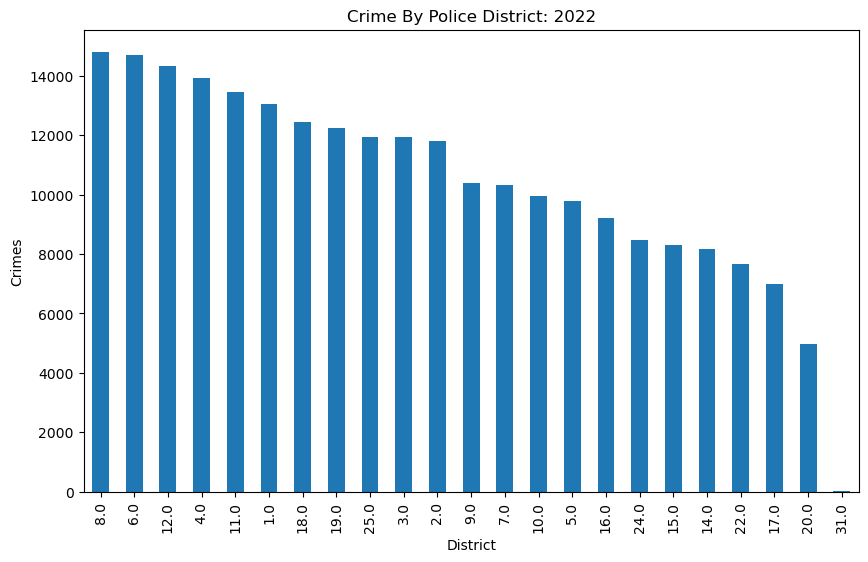

In [16]:
plt.figure(figsize=(10, 6))  # Set the figure size
count.plot(kind='bar')
plt.title('Crime By Police District: 2022')
plt.xlabel('District')
plt.ylabel('Crimes')

### Answer:

The distrct with the Most crimes in 2022: District 8

The distrct with the Least crimes in 2022: Distrct 31

## Topic 2: Crimes Across the Years

- Is the total number of crimes increasing or decreasing across the years?
- Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?

In [17]:
df_2 = crime_df[['Primary Type']]
df_2

,Primary Type
Date,
2001-01-01 01:00:00,CRIM SEXUAL ASSAULT
2001-01-01 01:00:00,ASSAULT
2001-01-01 01:00:00,BATTERY
2001-01-01 01:00:00,OFFENSE INVOLVING CHILDREN
2001-01-01 01:00:00,THEFT
...,...
2022-12-31 12:50:00,ASSAULT
2022-12-31 12:50:00,ASSAULT
2022-12-31 12:52:00,BATTERY


In [18]:
# Resample by Year
df_2_annual = df_2.resample('A').count().copy()
df_2_annual

,Primary Type
Date,
2001-12-31,485886
2002-12-31,486807
2003-12-31,475985
2004-12-31,469422
2005-12-31,453773
2006-12-31,448179
2007-12-31,437087
2008-12-31,427183
2009-12-31,392827


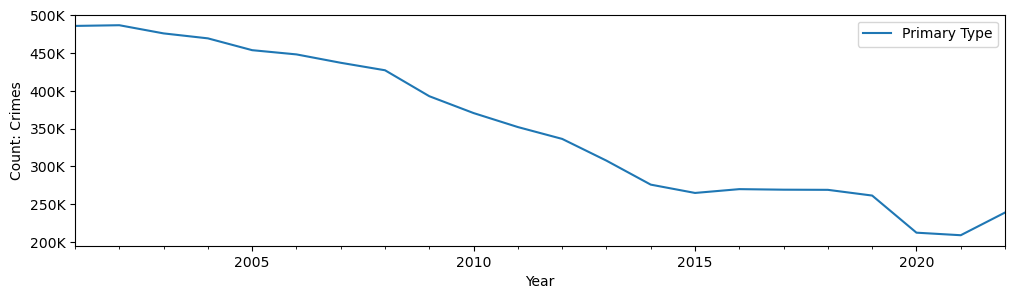

In [19]:
ax = df_2_annual.plot()
ax.set_ylabel('Count: Crimes')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(fmt_thous)

In [20]:
type_df = df_2.groupby('Primary Type').resample('A').count()
type_df

Primary Type
Primary Type      Date                    
ARSON             2001-12-31          1011
                  2002-12-31          1032
                  2003-12-31           955
                  2004-12-31           778
                  2005-12-31           691
...                                    ...
WEAPONS VIOLATION 2018-12-31          5456
                  2019-12-31          6339
                  2020-12-31          8432
                  2021-12-31          8980
                  2022-12-31          8766

[723 rows x 1 columns]

In [21]:
type_by_year = type_df.unstack(level=0)
type_by_year.columns

MultiIndex([('Primary Type',                             'ARSON'),
            ('Primary Type',                           'ASSAULT'),
            ('Primary Type',                           'BATTERY'),
            ('Primary Type',                          'BURGLARY'),
            ('Primary Type', 'CONCEALED CARRY LICENSE VIOLATION'),
            ('Primary Type',               'CRIM SEXUAL ASSAULT'),
            ('Primary Type',                   'CRIMINAL DAMAGE'),
            ('Primary Type',           'CRIMINAL SEXUAL ASSAULT'),
            ('Primary Type',                 'CRIMINAL TRESPASS'),
            ('Primary Type',                'DECEPTIVE PRACTICE'),
            ('Primary Type',                 'DOMESTIC VIOLENCE'),
            ('Primary Type',                          'GAMBLING'),
            ('Primary Type',                          'HOMICIDE'),
            ('Primary Type',                 'HUMAN TRAFFICKING'),
            ('Primary Type',  'INTERFERENCE WITH PUBLIC OFFICE

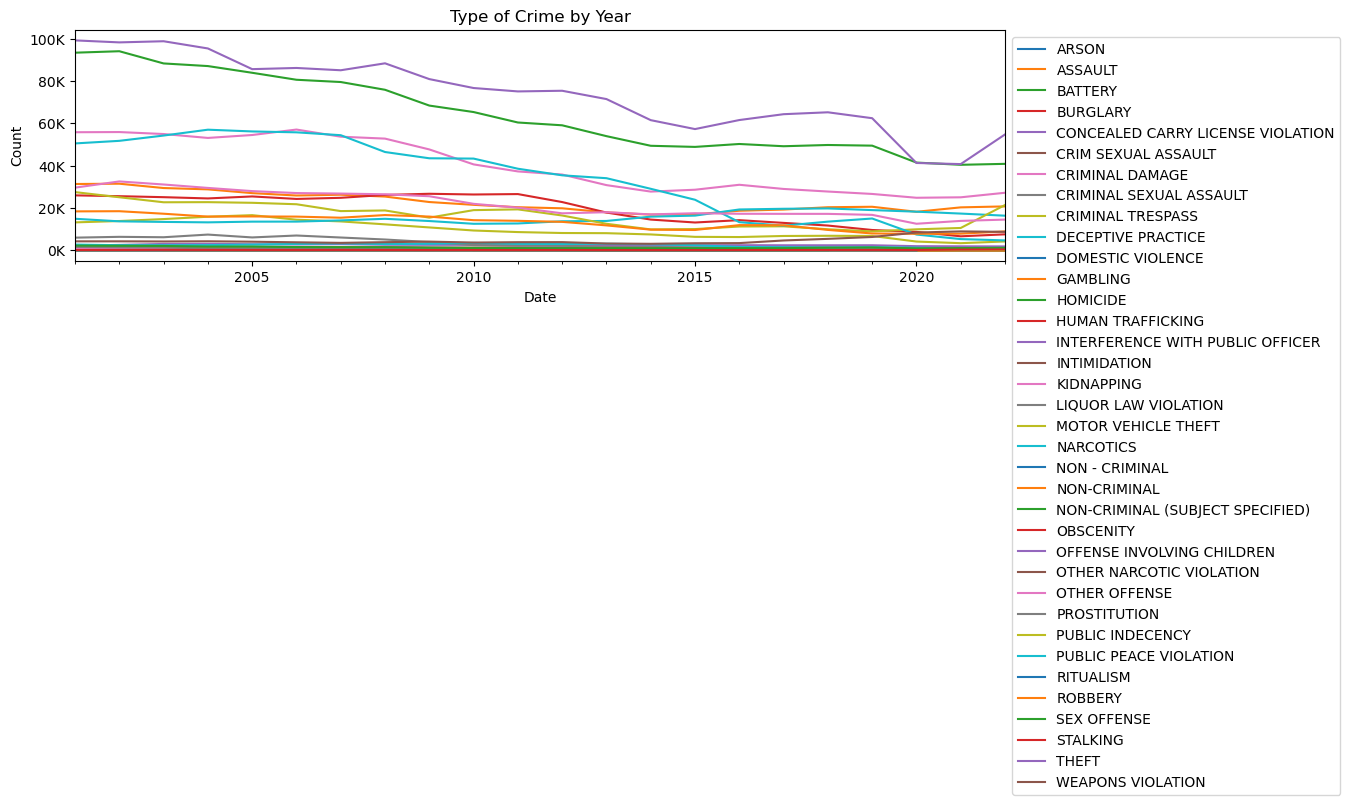

In [22]:
ax = type_by_year['Primary Type'].plot()
ax.set_title('Type of Crime by Year')
ax.set_ylabel('Count')
ax.yaxis.set_major_formatter(fmt_thous)
plt.legend(bbox_to_anchor = (1,1));

### Answer

It appears that Crime overall is decreasing according to our data and first visual.

In our second visual, we can see that nearly all of the crime is on a decrease. But the Concealed Carry License Violation and Criminal Trespass are both on the rise again.

## Topic 4) Comparing Months

In [23]:
df_3 = crime_df.copy()
df_3.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,3206463,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,True,835,8.0,18.0,41.735507,-87.690095
2001-01-01 01:00:00,1314713,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,1322,12.0,NaN,41.899521,-87.672220
2001-01-01 01:00:00,1317937,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,334,3.0,NaN,41.762514,-87.565877
2001-01-01 01:00:00,3212105,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,True,False,913,9.0,14.0,41.823730,-87.698440
2001-01-01 01:00:00,1310824,THEFT,$500 AND UNDER,BAR OR TAVERN,False,False,323,3.0,NaN,41.765484,-87.621836


In [24]:
df_3['Month'] = df_3.index.month
df_3['Month'].value_counts()

7     717232
8     710444
5     682932
6     681739
10    676285
9     668242
3     629704
4     627175
11    608961
1     601236
12    579768
2     529391
Name: Month, dtype: int64

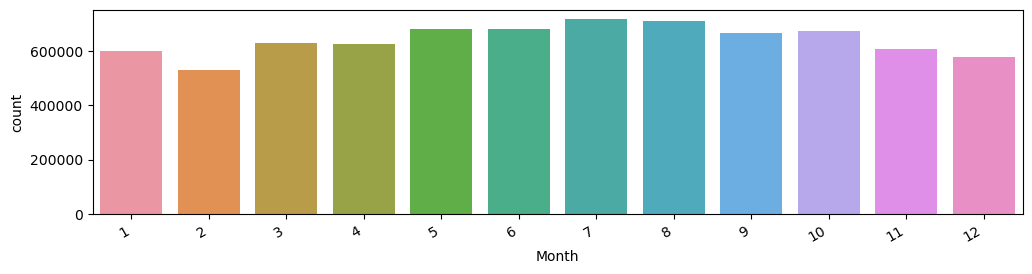

In [25]:
ax = sns.countplot (data = df_3, x=('Month'))
fig = ax.get_figure()
fig.autofmt_xdate()

In [26]:
monthly_crime = df_3.groupby('Primary Type')['Month'].value_counts().sort_index()
monthly_crime

Primary Type       Month
ARSON              1         917
                   2         807
                   3        1111
                   4        1097
                   5        1230
                            ... 
WEAPONS VIOLATION  8        9887
                   9        9435
                   10       9190
                   11       7952
                   12       7401
Name: Month, Length: 415, dtype: int64

In [27]:
unstacked = monthly_crime.unstack(level=0)

In [28]:
unstacked.columns

Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'DOMESTIC VIOLENCE', 'GAMBLING', 'HOMICIDE',
       'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION',
       'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT',
       'NARCOTICS', 'NON - CRIMINAL', 'NON-CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY',
       'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'SEX OFFENSE',
       'STALKING', 'THEFT', 'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type')

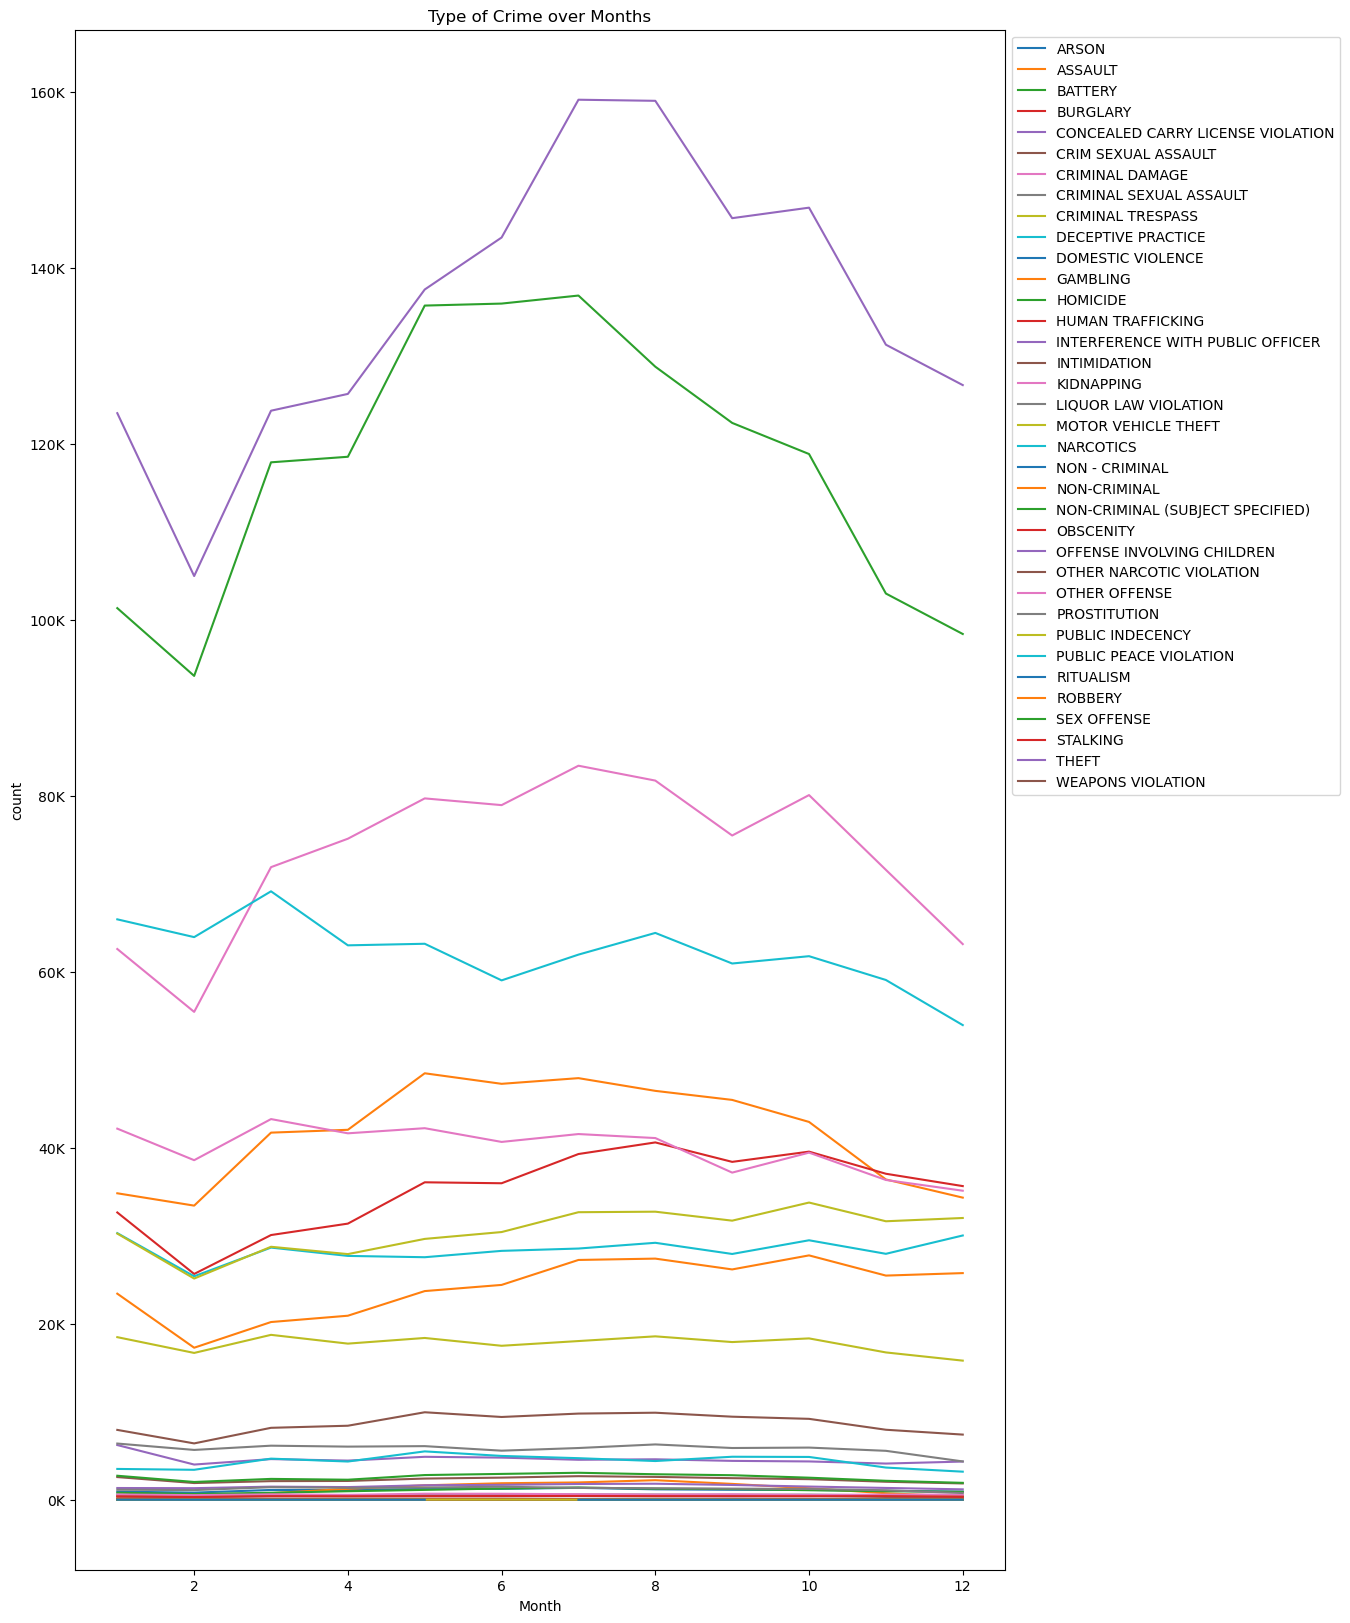

In [29]:
ax = unstacked.plot(figsize = (12,20))
ax.set_title('Type of Crime over Months')
ax.set_ylabel('count')
ax.yaxis.set_major_formatter(fmt_thous)
ax.legend(bbox_to_anchor=[1,1]);

### Answer

It appears from our visualizations that crime has spiked in the months of: July and August

BUT it appears to drop during the months of: November, December and February

WHen split up by type of crime, we see that most follow the patter or display no pattern by month. However, it does appear that Narcotics are higher in January/February and drop off during the summer.

# Part 2:

In [30]:
crime_df.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,3206463,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,True,835,8.0,18.0,41.735507,-87.690095
2001-01-01 01:00:00,1314713,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,1322,12.0,NaN,41.899521,-87.672220
2001-01-01 01:00:00,1317937,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,334,3.0,NaN,41.762514,-87.565877
2001-01-01 01:00:00,3212105,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,True,False,913,9.0,14.0,41.823730,-87.698440
2001-01-01 01:00:00,1310824,THEFT,$500 AND UNDER,BAR OR TAVERN,False,False,323,3.0,NaN,41.765484,-87.621836


In [33]:
temp_df = crime_df[['Primary Type', 'District']]
temp_df

,Primary Type,District
Date,,
2001-01-01 01:00:00,CRIM SEXUAL ASSAULT,8.0
2001-01-01 01:00:00,ASSAULT,12.0
2001-01-01 01:00:00,BATTERY,3.0
2001-01-01 01:00:00,OFFENSE INVOLVING CHILDREN,9.0
2001-01-01 01:00:00,THEFT,3.0
...,...,...
2022-12-31 12:50:00,ASSAULT,10.0
2022-12-31 12:50:00,ASSAULT,7.0
2022-12-31 12:52:00,BATTERY,11.0


In [34]:
temp_df.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 12:42:00',
               '2022-12-31 12:44:00', '2022-12-31 12:45:00',
               '2022-12-31 12:45:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 12:52:00',
               '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='Date', length=7713109, freq=None)

In [36]:
ts = temp_df.groupby('Primary Type').resample('MS').size()
ts

Primary Type       Date      
ARSON              2001-01-01     67
                   2001-02-01     57
                   2001-03-01     93
                   2001-04-01     89
                   2001-05-01     94
                                ... 
WEAPONS VIOLATION  2022-08-01    832
                   2022-09-01    780
                   2022-10-01    735
                   2022-11-01    597
                   2022-12-01    543
Length: 8602, dtype: int64

In [38]:
ts.index.get_level_values(0)

Index(['ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON',
       'ARSON', 'ARSON',
       ...
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type', length=8602)

In [39]:
ts.index.get_level_values(1)

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=8602, freq=None)

In [40]:
unstacked = ts.unstack(level=0)
unstacked

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,67.0,2123.0,6527.0,1934.0,NaN,162.0,3966.0,3.0,1192.0,1398.0,...,2800.0,563.0,NaN,161.0,2.0,1396.0,218.0,26.0,7867.0,337.0
2001-02-01,57.0,2029.0,6042.0,1666.0,NaN,134.0,3665.0,1.0,1063.0,1163.0,...,2488.0,426.0,1.0,173.0,0.0,1159.0,149.0,13.0,6669.0,301.0
2001-03-01,93.0,2824.0,7662.0,1832.0,NaN,149.0,4617.0,4.0,1141.0,1313.0,...,2836.0,550.0,0.0,267.0,2.0,1399.0,184.0,17.0,7766.0,345.0
2001-04-01,89.0,2746.0,8328.0,1932.0,NaN,132.0,4922.0,2.0,1133.0,1199.0,...,2483.0,564.0,1.0,229.0,1.0,1341.0,169.0,29.0,7702.0,321.0
2001-05-01,94.0,2903.0,8887.0,1997.0,1.0,155.0,4757.0,2.0,1067.0,1261.0,...,2528.0,503.0,1.0,239.0,1.0,1491.0,227.0,12.0,8420.0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,40.0,1984.0,3740.0,674.0,15.0,NaN,2713.0,145.0,392.0,1432.0,...,1214.0,23.0,1.0,56.0,NaN,749.0,127.0,48.0,5244.0,832.0
2022-09-01,49.0,1891.0,3723.0,653.0,13.0,NaN,2619.0,144.0,378.0,1540.0,...,1147.0,59.0,1.0,66.0,NaN,868.0,116.0,33.0,5117.0,780.0
2022-10-01,41.0,1839.0,3501.0,688.0,10.0,NaN,2834.0,162.0,374.0,1568.0,...,1166.0,26.0,1.0,72.0,NaN,945.0,91.0,46.0,5242.0,735.0


## Theft

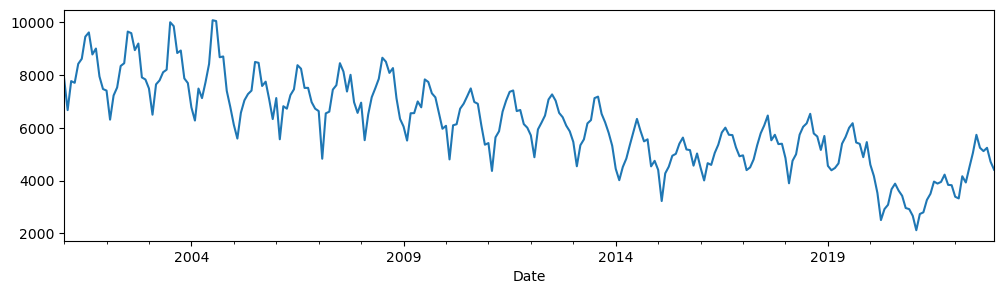

In [46]:
theft = unstacked['THEFT']
ax = theft.plot()

In [52]:
theft.isna().sum()

0

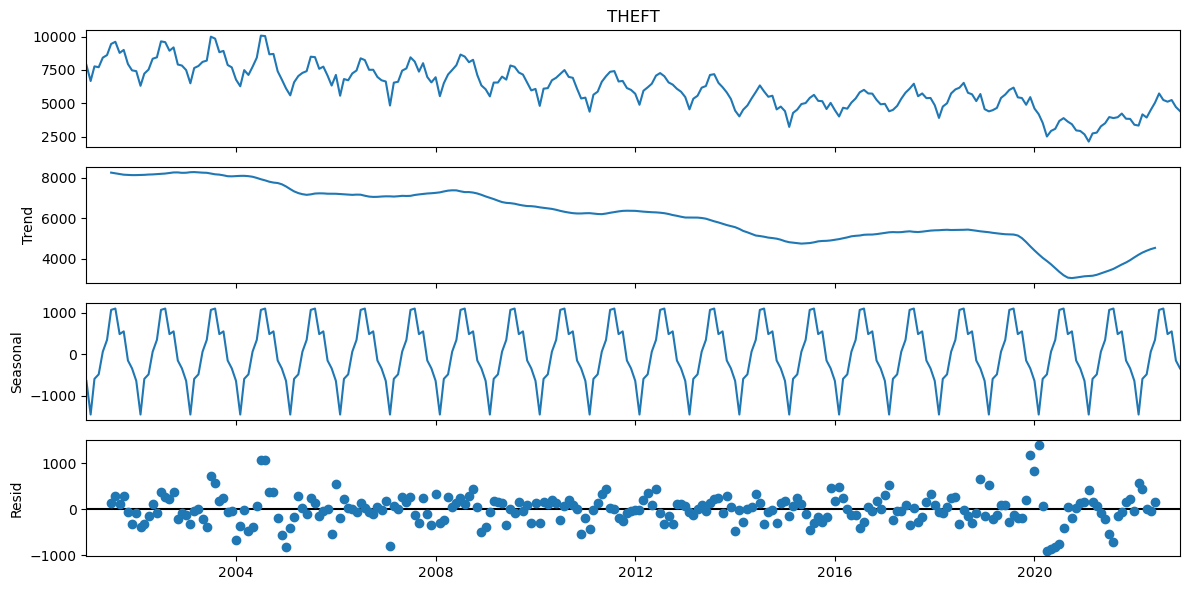

In [47]:
#seasonal 
decomp = tsa.seasonal_decompose(theft)
fig=decomp.plot()
fig.set_size_inches(12,6)
fig.tight_layout()

In [48]:
max = theft.max()
min = theft.min()

In [51]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(max-min) * 100 :.2f}% of the variation in time series.")

The seasonal component is  2549.99 which is ~32.08% of the variation in time series.


In [98]:
#adfuller
get_adfuller_results(theft)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


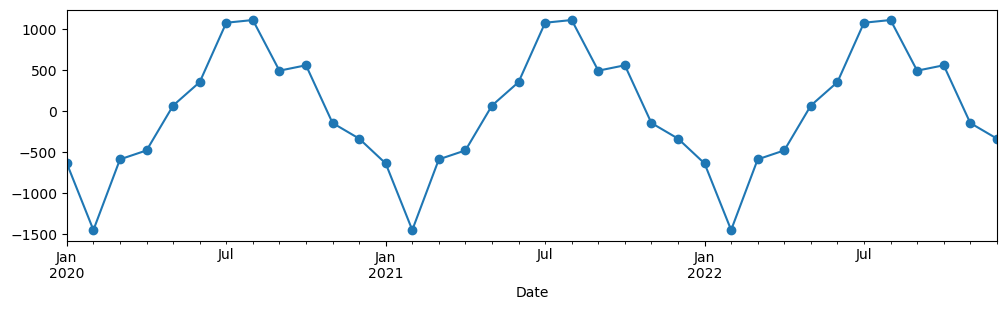

In [53]:
seasonal_theft = decomp.seasonal
ax = seasonal_theft.loc['2020':].plot(marker = 'o')

In [55]:
# d
d = ndiffs(theft)
d

1

In [56]:
# D
D = nsdiffs(theft, m=12)
D

0

In [57]:
theft_diffs = theft.diff().dropna()

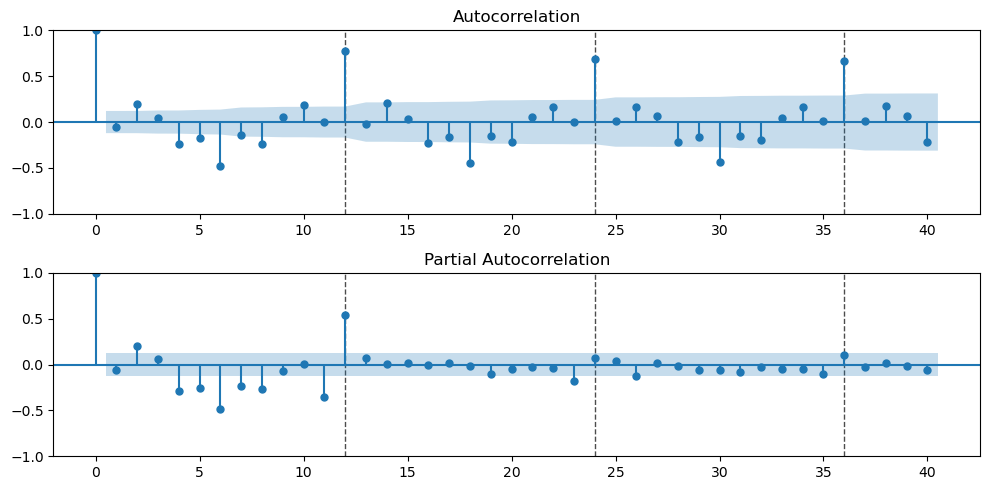

In [59]:
plot_acf_pacf(theft_diffs, annotate_seas=True, m=12);

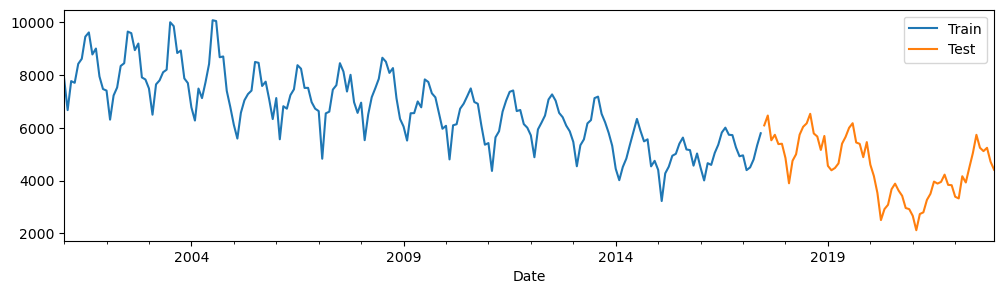

In [60]:
#Train/Test/Split
train, test = train_test_split(theft, test_size=.25)
ax=train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend()

In [61]:
# Order
p = 1
d = 0
q = 1

P = 0
D = 0
Q = 0
m = 12

In [62]:
sarima = tsa.ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2,086.441
- MSE = 5,718,058.125
- RMSE = 2,391.246
- R^2 = -3.710
- MAPE = 56.76%


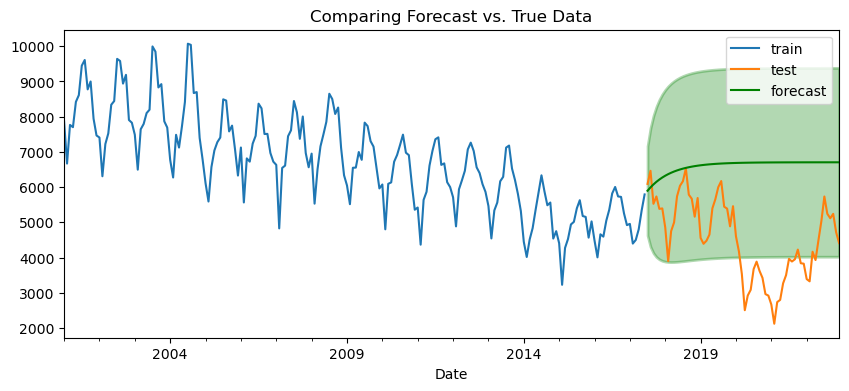

In [63]:
forecasted = sarima.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecasted)
regression_metrics_ts(test, forecasted['mean'])

In [64]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  THEFT   No. Observations:                  198
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1564.520
Date:                Fri, 03 Nov 2023   AIC                           3137.039
Time:                        07:12:05   BIC                           3150.192
Sample:                    01-01-2001   HQIC                          3142.363
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6705.4546    397.410     16.873      0.000    5926.546    7484.363
ar.L1          0.8825      0.049     18.190      0.000       0.787       0.978
ma.L1         -0.0077      0.103     -0.075      0.940      -0.210       0.195
sigma2      4.193e+05   4.45e+04      9.432      0.000    3.32e+05    5.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.95   Prob(JB):                         0.90
Heteroskedasticity (H):               0.45   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

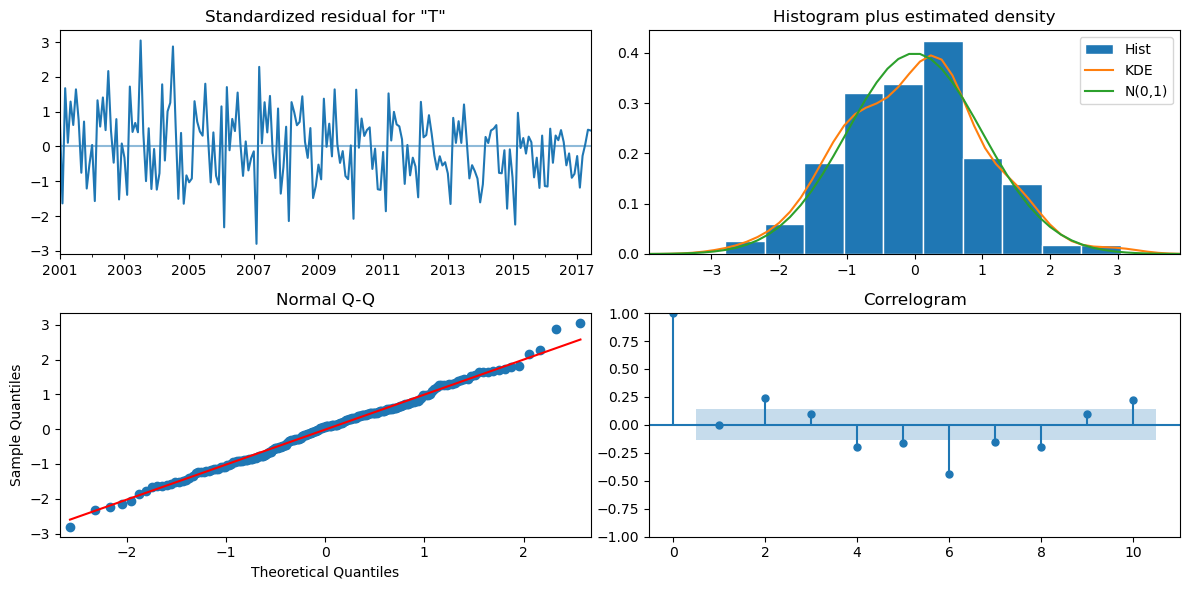

In [65]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(12,6)
fig.tight_layout()

In [66]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [0]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 0, 0, 0, 0, 0, 12),
 (0, 0, 0, 0, 0, 1, 12),
 (0, 0, 0, 0, 0, 2, 12),
 (0, 0, 0, 1, 0, 0, 12),
 (0, 0, 0, 1, 0, 1, 12),
 (0, 0, 0, 1, 0, 2, 12),
 (0, 0, 0, 2, 0, 0, 12),
 (0, 0, 0, 2, 0, 1, 12),
 (0, 0, 0, 2, 0, 2, 12),
 (0, 0, 1, 0, 0, 0, 12)]

In [67]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmod

(0, 0, 0, 0, 0, 0, 12) 3430.4643616457292
(0, 0, 0, 0, 0, 1, 12) 3261.8774871680107


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 0, 0, 2, 12) 3156.720062325692


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 1, 0, 0, 12) 3052.6903982503204


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 1, 0, 1, 12) 3052.6270889030857


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 1, 0, 2, 12) 3054.5750079987533


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 2, 0, 0, 12) 3052.785428847699


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 2, 0, 1, 12) 3054.5887488355565


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 2, 0, 2, 12) 3056.5383705157956
(0, 0, 1, 0, 0, 0, 12) 3282.859701271689


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmod

(0, 0, 1, 0, 0, 1, 12) 3138.0319137289657


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 0, 0, 2, 12) 3061.025421778606


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 1, 0, 0, 12) 2968.7626540288497


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 1, 0, 1, 12) 2970.4984826110203


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 1, 0, 2, 12) 2971.489876334735


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 2, 0, 0, 12) 2970.5541651314516


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(0, 0, 1, 2, 0, 1, 12) 2972.763024456068


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(0, 0, 1, 2, 0, 2, 12) 2973.9238266068114
(0, 0, 2, 0, 0, 0, 12) 3222.839550044765


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 0, 0, 1, 12) 3089.660582839737


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 0, 0, 2, 12) 3028.3253923406073


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 1, 0, 0, 12) 2938.813937160291


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 1, 0, 1, 12) 2936.0981923605364


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/pytho

(0, 0, 2, 1, 0, 2, 12) 3025.740280654595
(0, 0, 2, 2, 0, 0, 12) 2936.943317305537


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 2, 0, 1, 12) 2942.8070766527508


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 2, 0, 2, 12) 3032.2430436497425
(1, 0, 0, 0, 0, 0, 12) 3135.041398846297


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmod

(1, 0, 0, 0, 0, 1, 12) 3020.4678409381772


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 0, 0, 2, 12) 2973.005118732169


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 1, 0, 0, 12) 2896.167003428225


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 1, 0, 1, 12) 2872.2068714806674


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 1, 0, 2, 12) 2872.869566580811


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 2, 0, 0, 12) 2884.848857487362


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(1, 0, 0, 2, 0, 1, 12) 2884.615680052004
(1, 0, 0, 2, 0, 2, 12): caused an error
(1, 0, 1, 0, 0, 0, 12) 3137.0393179253133


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmod

(1, 0, 1, 0, 0, 1, 12) 3021.6481796160424


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 0, 0, 2, 12) 2973.1808279936813


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 1, 0, 0, 12) 2888.3258179511104


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(1, 0, 1, 1, 0, 1, 12) 2890.246802192478


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 1, 0, 2, 12) 2857.413333550082
(1, 0, 1, 2, 0, 0, 12) 2873.9190203335847


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(1, 0, 1, 2, 0, 1, 12) 2895.4494045139977
(1, 0, 1, 2, 0, 2, 12): caused an error
(1, 0, 2, 0, 0, 0, 12) 3121.048709761558


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmod

(1, 0, 2, 0, 0, 1, 12) 3015.120567944612


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(1, 0, 2, 0, 0, 2, 12) 2969.5628366991004
(1, 0, 2, 1, 0, 0, 12) 2890.2808676421914


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 1, 0, 1, 12) 2858.8553792841794


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 1, 0, 2, 12) 2870.0842163699926


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 2, 0, 0, 12) 2875.9091233456347


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(1, 0, 2, 2, 0, 1, 12) 2868.0560083889623


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 2, 0, 2, 12) 2916.8191493361983
(2, 0, 0, 0, 0, 0, 12) 3137.0223552440834


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 0, 0, 1, 12) 3021.3156467650288


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 0, 0, 0, 2, 12) 2972.620837103992
(2, 0, 0, 1, 0, 0, 12) 2888.9408632184945


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 1, 0, 1, 12) 2859.6254828943474


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 1, 0, 2, 12) 2860.1144752159785


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 2, 0, 0, 12) 2874.682636224486


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 2, 0, 1, 12): caused an error


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 0, 2, 0, 2, 12) 2931.7923257114276
(2, 0, 1, 0, 0, 0, 12) 3138.044556625455


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(2, 0, 1, 0, 0, 1, 12) 3022.475531925384


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(2, 0, 1, 0, 0, 2, 12) 2987.341557299148
(2, 0, 1, 1, 0, 0, 12) 2900.084243575419


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(2, 0, 1, 1, 0, 1, 12): caused an error


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 1, 1, 0, 2, 12) 2899.5768374673817


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(2, 0, 1, 2, 0, 0, 12): caused an error


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 1, 2, 0, 1, 12) 16.0


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(2, 0, 1, 2, 0, 2, 12) 2944.5085733309666
(2, 0, 2, 0, 0, 0, 12) 3095.731562767147


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 0, 0, 1, 12) 3000.642876068372


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 2, 0, 0, 2, 12) 2977.051657801534


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 1, 0, 0, 12) 2891.8886273674943
(2, 0, 2, 1, 0, 1, 12) 2860.1766749683397


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 2, 1, 0, 2, 12) 2860.8804096221847


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 2, 0, 0, 12) 2879.309351857766
(2, 0, 2, 2, 0, 1, 12): caused an error


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 2, 0, 2, 12) 2938.90979632322
Best AIC: 16.0
Best pdqPDQm: (2, 0, 1, 2, 0, 1, 12)


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best AIC: 16.0

Best pdqPDQm: (2, 0, 1, 2, 0, 1, 12)

In [68]:
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3128.037, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2897.254, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3017.305, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3126.088, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3128.164, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2861.575, Time=0.80 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3016.289, Time=0.33 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2861.049, Time=1.84 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2971.384, Time=1.09 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2878.462, Time=1.66 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : 

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,1)(1,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/si

 ARIMA(2,1,1)(1,0,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,0,2)[12]             : AIC=inf, Time=3.23 sec
 ARIMA(3,1,1)(1,0,2)[12]             : AIC=inf, Time=2.76 sec

Best model:  ARIMA(2,1,0)(1,0,2)[12]          
Total fit time: 69.207 seconds


In [69]:
# Orders for non seasonal components
p = 2 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 854.264
- MSE = 1,443,401.457
- RMSE = 1,201.416
- R^2 = -0.189
- MAPE = 24.82%


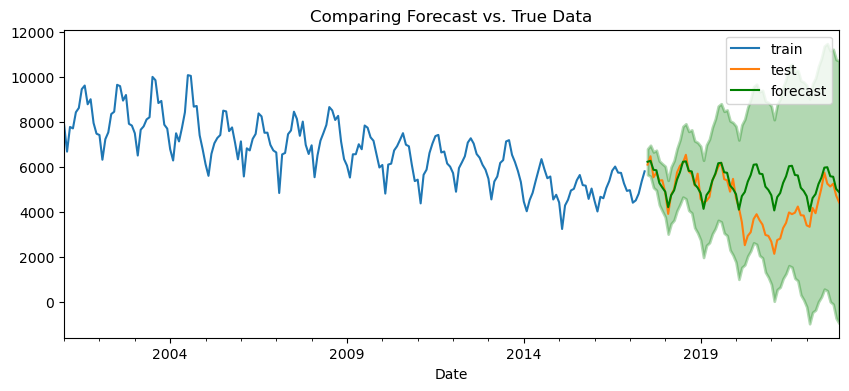

In [70]:
new_forecasted = sarima.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, new_forecasted)
regression_metrics_ts(test, new_forecasted['mean'])

### Model Comparison

Model 1:
- MAE = 2,086.441
- MSE = 5,718,058.125
- RMSE = 2,391.246
- R^2 = -3.710
- MAPE = 56.76%

Model 2: auto
- MAE = 854.264
- MSE = 1,443,401.457
- RMSE = 1,201.416
- R^2 = -0.189
- MAPE = 24.82%

Based on the provided metrics, Model 2 is the better-performing model. It has significantly lower errors (MAE, MSE, RMSE), a relatively better R² value, and a lower MAPE. 

### Future Forecast

In [71]:
theft_final_model = tsa.ARIMA(theft, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,166.125
- MSE = 1,939,612.133
- RMSE = 1,392.700
- R^2 = -0.598
- MAPE = 29.04%


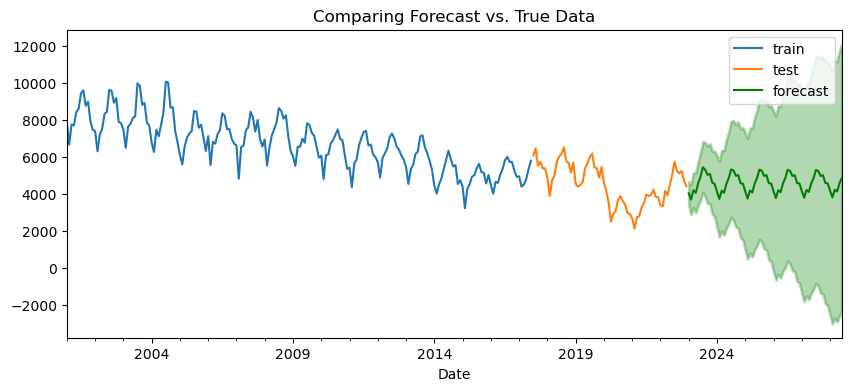

In [72]:
future = theft_final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, future)
regression_metrics_ts(test, future['mean'])

In [73]:
future.index[0], future.index[-1]

(Timestamp('2023-01-01 00:00:00', freq='MS'),
 Timestamp('2028-06-01 00:00:00', freq='MS'))

In [74]:
future

THEFT,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,4035.126625,321.319970,3405.351055,4664.902194
2023-02-01,3693.681526,405.421081,2899.070808,4488.292243
2023-03-01,4204.314202,480.009366,3263.513132,5145.115272
2023-04-01,4061.525958,544.208338,2994.897215,5128.154702
2023-05-01,4573.783490,601.555407,3394.756557,5752.810423
...,...,...,...,...
2028-02-01,3818.451514,3492.212863,-3026.159924,10663.062952
2028-03-01,4226.134961,3547.783816,-2727.393543,11179.663465
2028-04-01,4127.787443,3602.473270,-2932.930421,11188.505307
2028-05-01,4579.385601,3656.340847,-2586.910774,11745.681977


### Questions:
Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.

Convert the raw delta into a percent change.

In [75]:
first = future['mean'].iloc[0]
first

4035.1266245978577

In [76]:
last = future['mean'].iloc[5]
last

4931.407917440454

In [77]:
difference = last - first
difference

896.2812928425965

In [78]:

percent_difference = (difference / first) * 100
percent_difference

22.211974399487904

About a 896.28 or %22 increase in Theft predicted.

## Narcotics

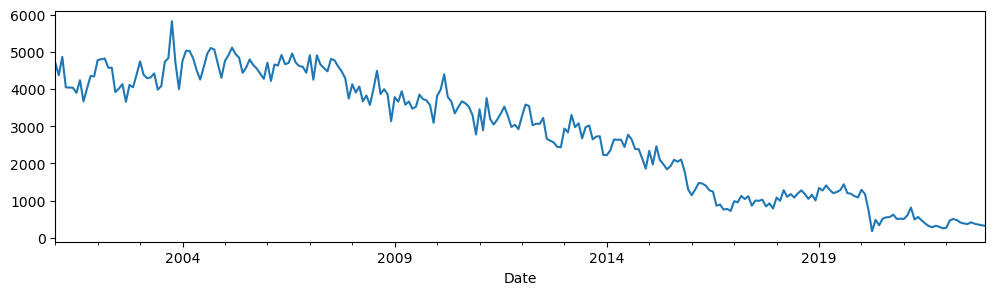

In [79]:
narcos = unstacked['NARCOTICS']
ax = narcos.plot()

In [80]:
narcos.isna().sum()

0

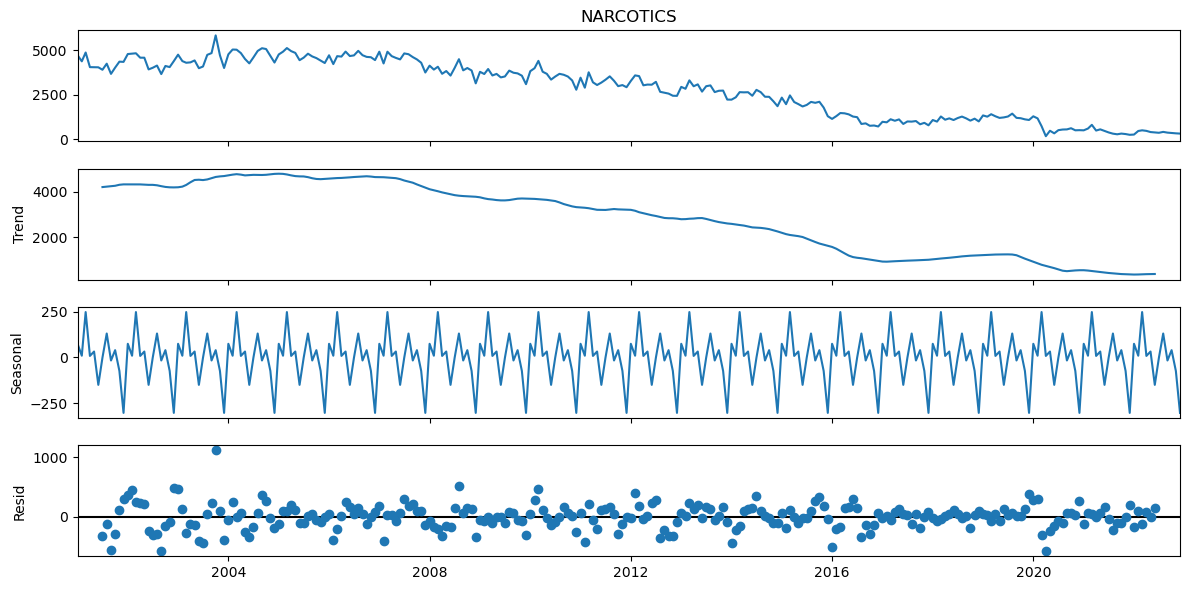

In [81]:
#seasonal 
decomp = tsa.seasonal_decompose(narcos)
fig=decomp.plot()
fig.set_size_inches(12,6)
fig.tight_layout()

In [82]:
max = narcos.max()
min = narcos.min()

In [83]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(max-min) * 100 :.2f}% of the variation in time series.")

The seasonal component is  550.66 which is ~9.76% of the variation in time series.


In [99]:

#adfuller
get_adfuller_results(narcos)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.265472,12,251,0.975704,0.05,False


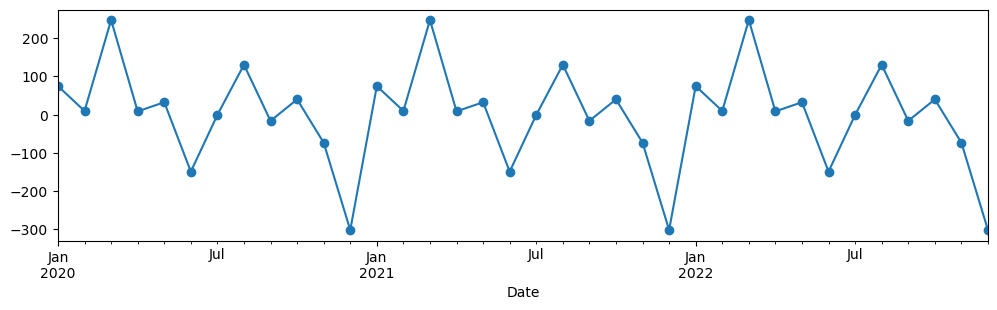

In [84]:
seasonal_narcos = decomp.seasonal
ax = seasonal_narcos.loc['2020':].plot(marker = 'o')

In [85]:
# d
d = ndiffs(narcos)
d

1

In [86]:
# D
D = nsdiffs(narcos, m=12)
D

0

In [87]:
narcos_diffs = narcos.diff().dropna()

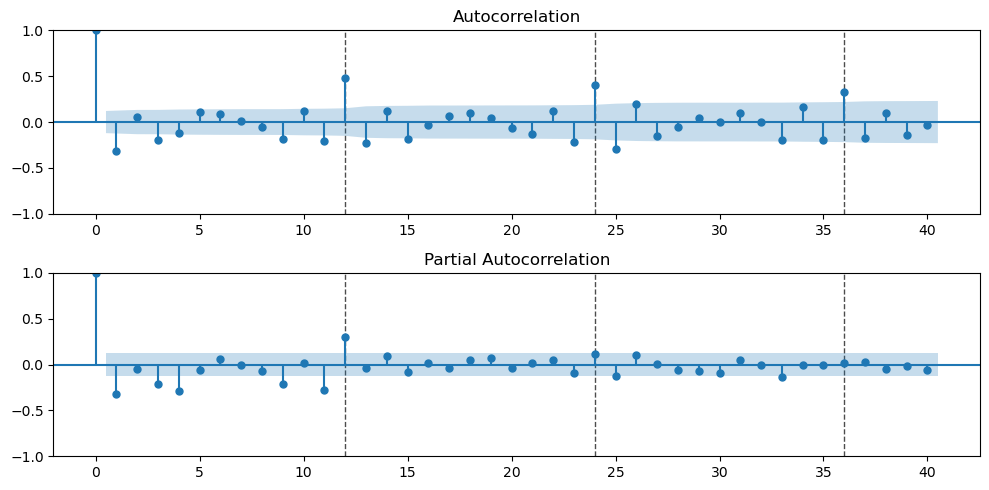

In [89]:
plot_acf_pacf(narcos_diffs, annotate_seas=True, m=12);

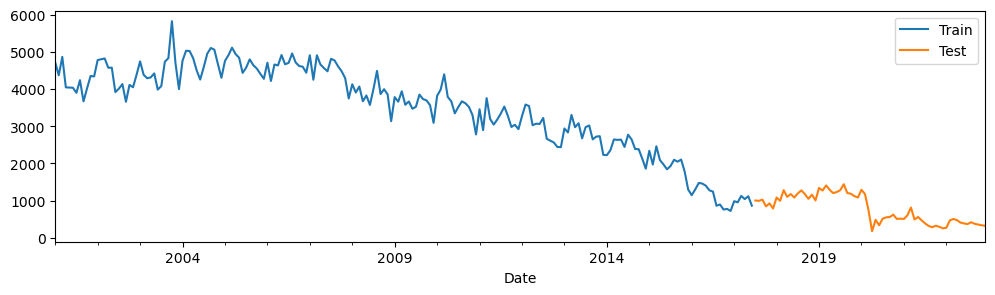

In [90]:
#Train/Test/Split
train, test = train_test_split(narcos, test_size=.25)
ax=train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend()

In [91]:
# Order
p = 1
d = 0
q = 1

P = 1
D = 0
Q = 0
m = 12

In [92]:
sarima = tsa.ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,114.450
- MSE = 2,062,019.438
- RMSE = 1,435.973
- R^2 = -13.306
- MAPE = 267.24%


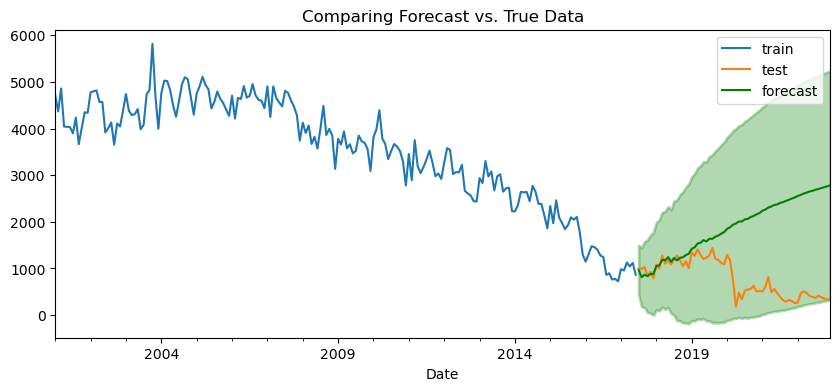

In [93]:
forecasted = sarima.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecasted)
regression_metrics_ts(test, forecasted['mean'])

In [94]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         NARCOTICS   No. Observations:                  198
Model:             ARIMA(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -1394.242
Date:                           Fri, 03 Nov 2023   AIC                           2798.484
Time:                                   07:35:27   BIC                           2814.926
Sample:                               01-01-2001   HQIC                          2805.139
                                    - 06-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3506.7740    817.455      4.290      0.000    1904.591    5108.957
ar.L1          0.9726      0.021     47.031      0.000       0.932       1.013
ma.L1         -0.3434      0.064     -5.407      0.000      -0.468      -0.219
ar.S.L12       0.5011      0.065      7.744      0.000       0.374       0.628
sigma2      7.401e+04   6255.490     11.831      0.000    6.18e+04    8.63e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                17.84
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

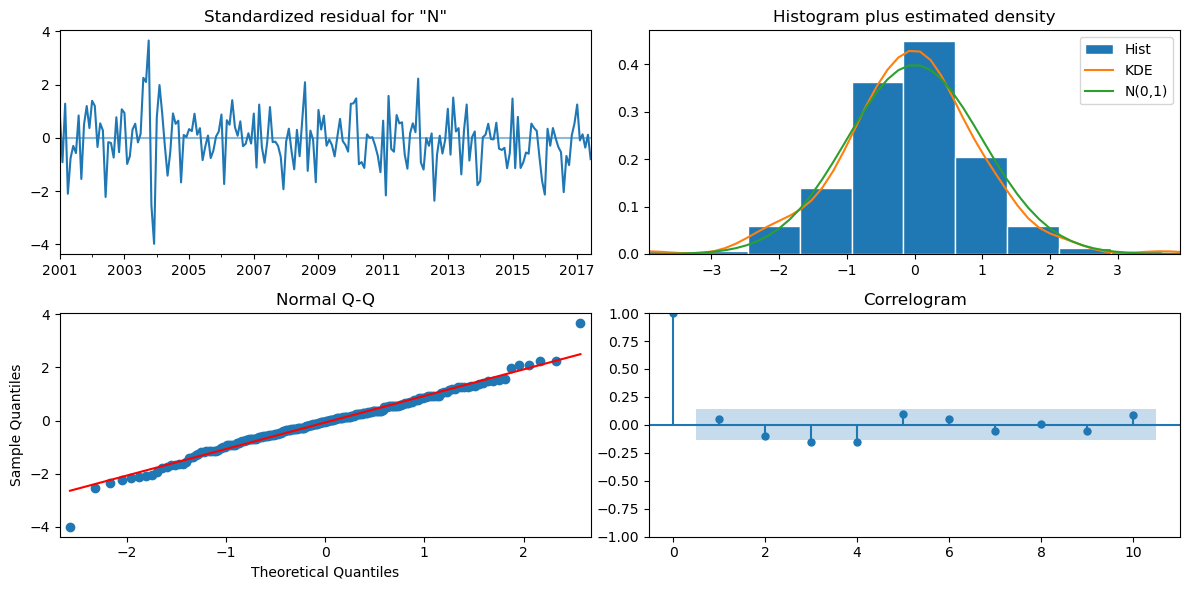

In [95]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(12,6)
fig.tight_layout()

In [96]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [0]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 0, 0, 0, 0, 0, 12),
 (0, 0, 0, 0, 0, 1, 12),
 (0, 0, 0, 0, 0, 2, 12),
 (0, 0, 0, 1, 0, 0, 12),
 (0, 0, 0, 1, 0, 1, 12),
 (0, 0, 0, 1, 0, 2, 12),
 (0, 0, 0, 2, 0, 0, 12),
 (0, 0, 0, 2, 0, 1, 12),
 (0, 0, 0, 2, 0, 2, 12),
 (0, 0, 1, 0, 0, 0, 12)]

In [97]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmod

(0, 0, 0, 0, 0, 0, 12) 3361.3085172616566
(0, 0, 0, 0, 0, 1, 12) 3206.2427570043355


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 0, 0, 2, 12) 3144.295134135887


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 0, 1, 0, 0, 12) 3035.1369581730487


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 0, 1, 0, 1, 12) 3032.0763670128754


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 0, 1, 0, 2, 12) 3031.509608979429


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 0, 2, 0, 0, 12) 3029.8909220861096


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(0, 0, 0, 2, 0, 1, 12) 2983.7023614544623


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 2, 0, 2, 12) 3006.012897828845
(0, 0, 1, 0, 0, 0, 12) 3186.818571671429


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 0, 0, 1, 12) 3071.349873442765


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 0, 0, 2, 12) 2999.253222758921


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 1, 1, 0, 0, 12) 2919.701314180332


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 1, 1, 0, 1, 12) 2923.692678421151


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(0, 0, 1, 1, 0, 2, 12) 2947.8604985224306
(0, 0, 1, 2, 0, 0, 12) 2923.4650567606573


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 1, 2, 0, 1, 12) 3039.5512118306397


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 1, 2, 0, 2, 12) 3027.579440474403


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 2, 0, 0, 0, 12) 3076.5637035297796


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 2, 0, 0, 1, 12) 2994.9715972067625


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 2, 0, 0, 2, 12) 2937.7451520341124


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 2, 1, 0, 0, 12) 2892.9390604670352


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 2, 1, 0, 1, 12) 2892.381240474211


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 2, 1, 0, 2, 12) 2889.75793796555


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 2, 2, 0, 0, 12) 2891.3408368276814


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 2, 2, 0, 1, 12) 2891.7766351602686


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(0, 0, 2, 2, 0, 2, 12) 2926.642958906793
(1, 0, 0, 0, 0, 0, 12) 2869.303580219752


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 0, 0, 1, 12) 2834.546302909752


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 0, 0, 2, 12) 2811.935890667367


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 0, 1, 0, 0, 12) 2808.2857388952393


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 0, 1, 0, 1, 12) 2788.203684093469


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 0, 1, 0, 2, 12) 2789.7286944724997


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 0, 2, 0, 0, 12) 2797.242053761125


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(1, 0, 0, 2, 0, 1, 12) 2793.3426114802896


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 2, 0, 2, 12) 2791.1837928497625
(1, 0, 1, 0, 0, 0, 12) 2847.3222629718666


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 0, 0, 1, 12) 2815.3375077836868


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 0, 0, 2, 12) 2803.4822592147284


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 1, 1, 0, 0, 12) 2798.484287593953


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 1, 1, 0, 1, 12) 2783.0878914079667


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(1, 0, 1, 1, 0, 2, 12) 2785.4929885419688
(1, 0, 1, 2, 0, 0, 12) 2792.806639408906


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 1, 2, 0, 1, 12) 2783.854876567597


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(1, 0, 1, 2, 0, 2, 12) 2787.347836422031
(1, 0, 2, 0, 0, 0, 12) 2845.069622909169


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 0, 2, 0, 0, 1, 12) 2812.803575461975


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 0, 2, 0, 0, 2, 12) 2798.4419781003467


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(1, 0, 2, 1, 0, 0, 12) 2793.847087635343


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(1, 0, 2, 1, 0, 1, 12) 2776.409155421754


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(1, 0, 2, 1, 0, 2, 12) 2777.754870536023


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(1, 0, 2, 2, 0, 0, 12) 2784.968777284008


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(1, 0, 2, 2, 0, 1, 12) 2778.6090715197524


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 2, 0, 2, 12) 2782.0862867952737
(2, 0, 0, 0, 0, 0, 12) 2852.0910217783576


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 0, 0, 1, 12) 2820.2853573127995


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 0, 0, 2, 12) 2806.899498737977


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 0, 1, 0, 0, 12) 2802.2066507463524


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 0, 1, 0, 1, 12) 2785.4537374153056


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(2, 0, 0, 1, 0, 2, 12) 2786.3330468989952
(2, 0, 0, 2, 0, 0, 12) 2795.3632894861726


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 0, 2, 0, 1, 12) 2786.4431608060263


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(2, 0, 0, 2, 0, 2, 12) 2789.8090799294678
(2, 0, 1, 0, 0, 0, 12) 2842.0064707820447


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 1, 0, 0, 1, 12) 2809.57924700911


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 1, 0, 0, 2, 12) 2795.119725129648


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 1, 1, 0, 0, 12) 2790.3356376625825
(2, 0, 1, 1, 0, 1, 12) 2776.7825437393094


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 1, 1, 0, 2, 12) 2777.870950737153


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib

(2, 0, 1, 2, 0, 0, 12) 2782.527023584029
(2, 0, 1, 2, 0, 1, 12) 2777.8827156993093


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 1, 2, 0, 2, 12): caused an error


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/d

(2, 0, 2, 0, 0, 0, 12) 2843.2070401757774


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 2, 0, 0, 1, 12) 2812.3730517812774


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 2, 0, 0, 2, 12) 2800.253637649409


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 2, 1, 0, 0, 12) 2795.282314990429


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 2, 1, 0, 1, 12) 2778.57524386369


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 1, 0, 2, 12) 2779.9978566476207


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._in

(2, 0, 2, 2, 0, 0, 12) 2788.0883874254755


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/sit

(2, 0, 2, 2, 0, 1, 12) 2786.226729624844


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 2, 2, 0, 2, 12) 2787.933199630842
Best AIC: 2776.409155421754
Best pdqPDQm: (1, 0, 2, 1, 0, 1, 12)


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
Best AIC: 2776.409155421754
Best pdqPDQm: (1, 0, 2, 1, 0, 1, 12)

In [101]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2851.920, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2784.495, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2793.217, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2850.596, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2831.775, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2778.838, Time=1.28 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2765.339, Time=0.79 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2800.219, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2789.200, Time=0.77 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2770.286, Time=0.58 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

In [102]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 769.444
- MSE = 682,838.009
- RMSE = 826.340
- R^2 = -3.737
- MAPE = 131.94%


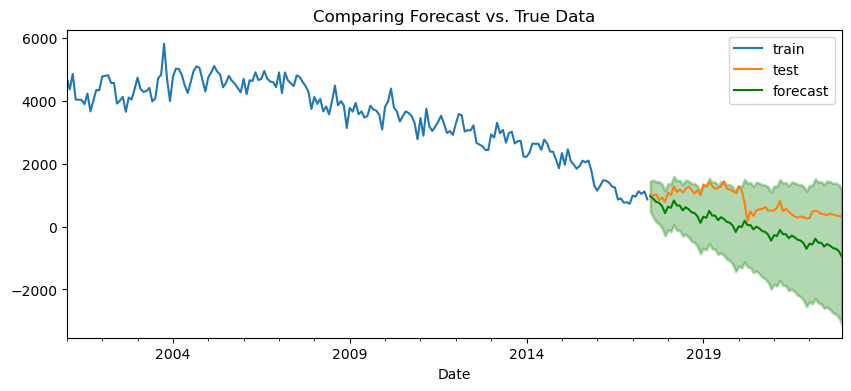

In [103]:
new_forecasted = sarima.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, new_forecasted)
regression_metrics_ts(test, new_forecasted['mean'])

### Model Comparison

Model 1:

MAE = 1,114.450
MSE = 2,062,019.438
RMSE = 1,435.973
R-squared (R²) = -13.306
MAPE = 267.24%
Model 2: auto

MAE = 769.444
MSE = 682,838.009
RMSE = 826.340
R-squared (R²) = -3.737
MAPE = 131.94%

Model 2 is the better-performing model. It has lower errors (MAE, MSE, RMSE), a relatively better R² value, and a lower MAPE. 


### Future Forecasting

In [105]:
narcos_final_model = tsa.ARIMA(narcos, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 791.024
- MSE = 693,314.232
- RMSE = 832.655
- R^2 = -3.810
- MAPE = 115.69%


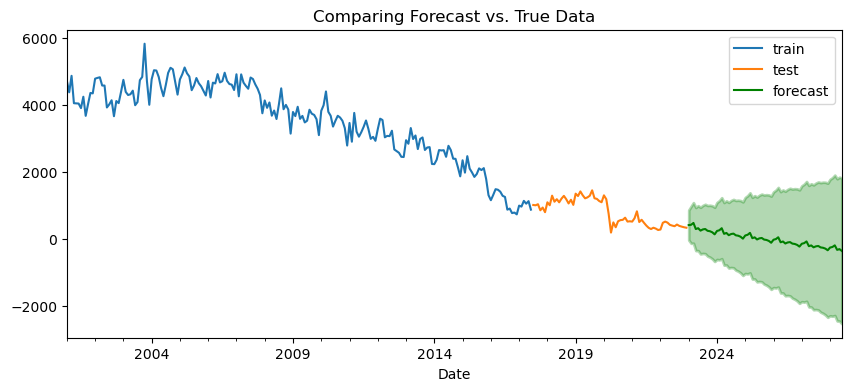

In [106]:
future = narcos_final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, future)
regression_metrics_ts(test, future['mean'])

In [107]:
future.index[0], future.index[-1]

(Timestamp('2023-01-01 00:00:00', freq='MS'),
 Timestamp('2028-06-01 00:00:00', freq='MS'))

In [108]:
future

NARCOTICS,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,403.994185,227.797357,-42.480431,850.468801
2023-02-01,411.654522,281.129610,-139.349389,962.658432
2023-03-01,467.348332,309.513092,-139.286181,1073.982845
2023-04-01,285.721837,328.393880,-357.918341,929.362014
2023-05-01,310.380675,342.907715,-361.706097,982.467448
...,...,...,...,...
2028-02-01,-250.329915,1055.341772,-2318.761780,1818.101950
2028-03-01,-201.694907,1069.685443,-2298.239850,1894.850036
2028-04-01,-335.688106,1083.293978,-2458.905287,1787.529076
2028-05-01,-314.990780,1096.436865,-2463.967546,1833.985986


### Questions:

Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.

Convert the raw delta into a percent change.

In [109]:
first = future['mean'].iloc[0]
last = future['mean'].iloc[5]
difference = last - first
percent_difference = (difference / first) * 100

In [110]:
difference

-165.78765261294623

In [111]:
percent_difference

-41.0371383793122

About a -165.79 or %-41.0 increase in Theft predicted.

## Final Evaluation

Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?

- Theft (4862.877167)

Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?

- Theft. the change is 896.28 increase. Greater than the -166 for Narcos.

Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?

- Narcos, the change is predicted to be negative. But it is a %41 change and higher than theft at %22

### Recommendation

Based on the data collected and analyzed, our recommendation is to lower the focus of resources around Narcotics and increase the allocated resources for Theft.

The data clearly shows a trend of decreasing activity for Narcotics with a hope that it will reach nearly 0 soon; however, we are seeing the opposite clearly with Theft. The trend shows an increase in the overall activity and is predicted to increase by over %20.